## Counting bigrams


In [1]:
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [2]:
words = open("makemore/names.txt", "r").read().splitlines()
words[0:3]

['emma', 'olivia', 'ava']

In [3]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [4]:
chars = sorted(list(set("".join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {s: i for i, s in stoi.items()}

In [5]:
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

In [6]:
P = N.float() / N.sum(1, keepdim=True)

(-0.5, 26.5, 26.5, -0.5)

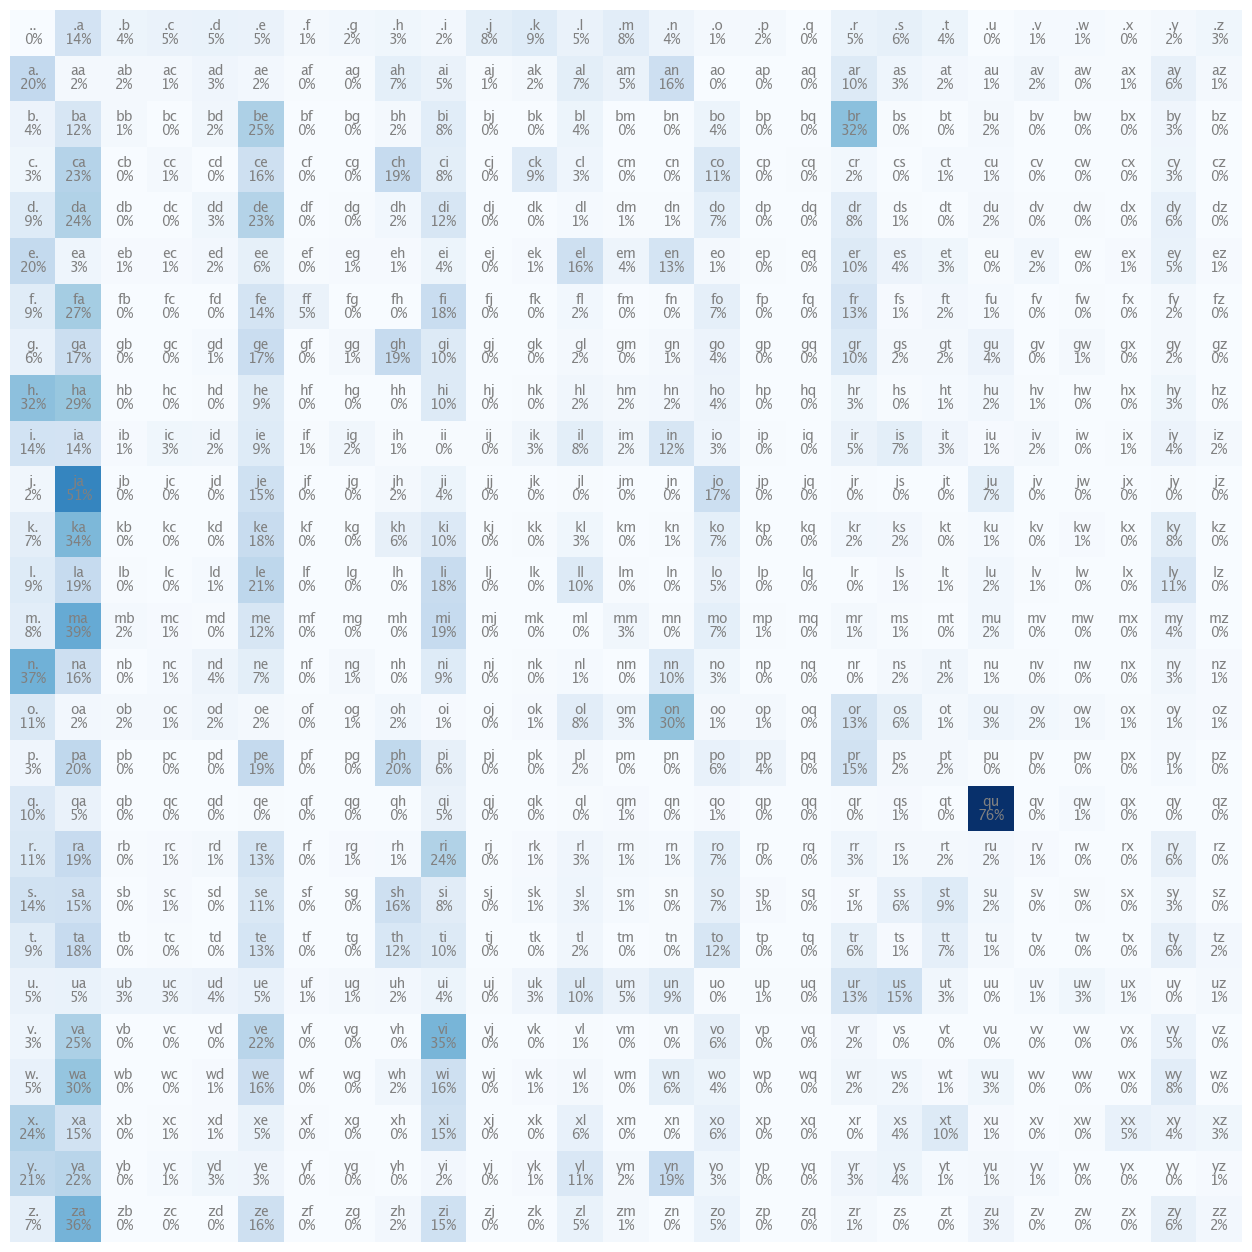

In [7]:
plt.figure(figsize=(16, 16))
plt.imshow(P, cmap="Blues")

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f"{P[i, j].item() * 100:.0f}%", ha="center", va="top", color="gray")

plt.axis("off")

In [8]:
g = torch.Generator().manual_seed(2147483647 + 2)


def make():
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            return "".join(out)


for i in range(10):
    print(make())

tayen.
aya.
jelievillaxa.
riran.
alanan.
ken.
ken.
lonniay.
zamas.
jete.


In [9]:
total_log = 0
n = 0

for word in words[:3]:
    for ch1, ch2 in zip(word, word[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        log = torch.log(prob)
        n += 1
        total_log += log
        print(
            f"{ch1}{ch2} | prob={prob:.3f} log={log.item():.3f}",
        )

print()
print(f"mean_loss={-total_log / n:.3f}")

em | prob=0.038 log=-3.279
mm | prob=0.025 log=-3.677
ma | prob=0.390 log=-0.942
ol | prob=0.078 log=-2.551
li | prob=0.178 log=-1.728
iv | prob=0.015 log=-4.187
vi | prob=0.354 log=-1.038
ia | prob=0.138 log=-1.980
av | prob=0.025 log=-3.704
va | prob=0.250 log=-1.388

mean_loss=2.447


## Neural Nets


In [10]:
import torch.nn.functional as F
import torch.nn as N

In [11]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

print()
print(f"{xs=} \n{ys=}")
print(f"Number of examples={xs.nelement()}")


xs=tensor([ 0,  5, 13,  ..., 25, 26, 24]) 
ys=tensor([ 5, 13, 13,  ..., 26, 24,  0])
Number of examples=228146


In [12]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [13]:
# Gradient descent

losses = []
for i in range(100):

    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()  # One hot encoded inputs
    logits = xenc @ W  # log(counts), [-Inf, +Inf]
    counts = logits.exp()  # counts, [0, +Inf]
    probs = counts / counts.sum(1, keepdim=True)  # Normalised probability with softmax.

    # NOTE: This array indexing here is impressively terse across 2 dimensions.
    # loss is Negative Log Likelihood
    nll = -probs[torch.arange(num), ys].log().mean()

    # Regularization loss
    reg = 0.01 * W.pow(2).mean()

    loss = nll + reg

    losses.append(loss.item())
    # print(f"loss={loss.item()}")

    # Backward pass
    W.grad = None
    loss.backward()

    # Update weights
    W.data += -50 * W.grad

start=3.7686, end=2.4901


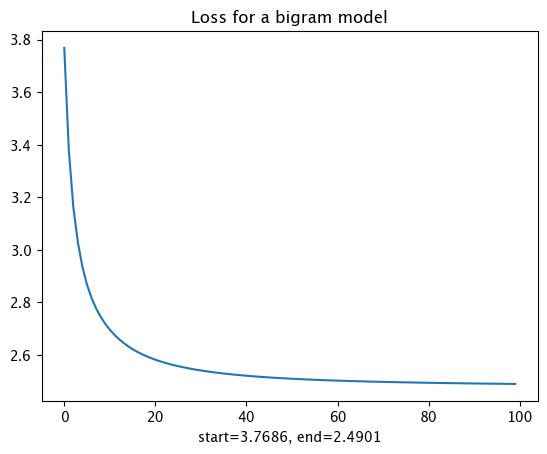

In [14]:
plt.plot(losses)
plt.title(f"Loss for a bigram model")
plt.xlabel(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")

# The expected loss at the end of training should be close to the mean loss calculated earlier
print(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")

In [15]:
# Sampling from model - Original version from talk

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W  # TODO: Replace one hot with array index?
        counts = logits.exp()  # Counts
        p = counts / counts.sum(1, keepdim=True)  # Use softmax maybe?

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


In [16]:
# Slightly tweaked version

g = torch.Generator().manual_seed(2147483647)
softmax = N.Softmax(dim=1)

for i in range(10):
    out = []
    ix = 0  # Char index, always starting at .
    while True:
        logits = W[ix].unsqueeze(0)
        p = softmax(logits)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
